#### TO DO  - Graph parent class
  - graph function - need to get x-plots to correctly generate when y =  constant
 - Add x and y intercepts to function_graph class
 - Optionally allow function graph ticks to equal the x and y intercepts
 - A straight line may or may not be a function, apply conditional composition? https://stackoverflow.com/questions/65754399/conditional-inheritance-based-on-arguments-in-pythonhttps://stackoverflow.com/questions/65754399/conditional-inheritance-based-on-arguments-in-python
 
 - or unheritance --> https://www.geeksforgeeks.org/conditional-inheritance-in-python/https://www.geeksforgeeks.org/conditional-inheritance-in-python/

#### TO DO
 - NB always use sympy data type in function calls e.g sp.Rational or sp.Float or sp.Integer 
  - how about making straight_line a class that inherits graph? https://www.datasnips.com/122/extend-__init__-method-when-inheriting-a-class/https://www.datasnips.com/122/extend-__init__-method-when-inheriting-a-class/
   - maybe apply all transformations on graph via another class
  - calc y-limits need to be updated for lines parallel to x-axis
  - calc x-limits need to be updated for lines parallel to y-axis
  - Need to handle straight line general form when a = 0 or b = 0.  See work started on _calc_subtype.  Also create an is_function property depending on type and subtype that drives whether functions are calculated.
  - Now that I have a graph type, it may be feasible to add circle to below
 - work on graphing the inverse - may has to be a little bit manual, use the graph type paramater in init
 - maybe work of graph transformation order page 65 of year 12 book
 - pass the raw function e.g cos (not say 3 * cos(x+2) to a function to determine the inverse
 - The issue is that the 0.5 is a float, rather than a sympy rational.  This works (tan(sp.Rational(1,2) * x) !
 - Draw arrows on graphs (although not if domain is restricted like arcos)


### <span style='color:brown'> Equation forms </span>
__Gradient intercept form__<br>
Line with a gradient of m and y-intercept of b<br>
$ y = mx + b $

__Point-gradient form__<br>
Line with a gradient of m that passes through point ($x_1, y_1$)<br>
$ y-y_1 = m (x-x_1) $


__Two-point form__<br>
Line that passes through points $(x_1, y_1)$ and $(x_2, y_2)$<br>
$ y-y_1 = \dfrac{y_2-y_1}{x_2-x_1} (x-x_1) $

__General form__<br>
$ ax + by + c = 0 $ <br>
where<br>
\* a, b, c are integers,<br>
\* a > 0

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import mpmath
plt.style.use('classic')
%matplotlib inline

In [10]:
 class graph_original:
    
    def __init__(self, graph_type, 
                 polynomial_coefficients=[],   #Ordered from leading coefficient to contsant
                 straight_line_gradient_intercept={}, #Dictionary containing gradient and interecept in format {'m': number, 'c': number}
                 straight_line_point_gradient = {}, #Dictionary in format ('x1':number, 'y1':number, 'm': number}
                 straight_line_two_point = {}, #Dictionary in format ('x1':number, 'y1':number, 'x2':number, 'y2':number}
                 straight_line_general_form = {}, #Dictionary in format ('a':number, 'b':number, 'c':number} for equation in the format ax + by + c = 0
                 domain_from = -10, domain_to=10, points_to_plot = 1000, fig_width=10, fig_height=10, 
                 x_tick_mark_type='standard', y_tick_mark_type='standard', graph_buffer_over_domain=0.1):   
        
        # Store graph type and any descriptive information as properties of glass
        self.type = graph_type
        self.polynomial_coefficients = polynomial_coefficients
        self.straight_line_gradient_intercept = straight_line_gradient_intercept
        self.straight_line_point_gradient = straight_line_point_gradient
        self.straight_line_two_point = straight_line_two_point
        self.straight_line_general_form = straight_line_general_form
        self.subtype = self._calc_subtype()
        
        #Other
        self.raw_fn = self._calc_raw_fn()
        self.fn = self._calc_fn()
        self.display_equation = self._calc_display_equation()
        self.domain_from = domain_from
        self.domain_to = domain_to
        self.domain_set = sp.Interval(domain_from,domain_to)
        self.points_to_plot = points_to_plot
        self.fig_height = fig_height
        self.fig_width = fig_width
        self.x_tick_mark_type = x_tick_mark_type
        self.y_tick_mark_type = y_tick_mark_type
        self.x_plots = self._calc_x_plots()
        self.y_plots = self._calc_y_plots()
        self.x_intercepts_sympy_rationals = self._calc_x_intercepts_sympy_rationals()
        self.x_intercepts_floats = self._calc_x_intercepts_floats()
        self.y_intercepts_sympy_rationals = self._calc_y_intercepts_sympy_rationals()
        self.y_intercepts_floats = self._calc_y_intercepts_floats()        
        self.graph_buffer_over_domain = graph_buffer_over_domain

    
    def _calc_subtype(self):
        '''Calculates whether graph is a specific sub-type requiring special treatment for example straight line paralellel to one of the axis'''
        
        if self.type =='straight line gradient intercept form' and self.straight_line_gradient_intercept['m']==0:
            return 'straight line parallel to x-axis' 
        else:
            return ('other')

        
    def _calc_raw_fn(self):
        '''Calcualtes the "raw" function of the graph with y as a subject before any transformations such as translation, dilation etc'''
        
        x = sp.symbols('x', real = True)
        
        if self.type == 'polynomial':
            raw_fn = 0
            leading_degree = len(self.polynomial_coefficients) - 1  #Deduct one, as the last coefficient is the constant
            current_degree = leading_degree
            for coefficient in self.polynomial_coefficients:
                raw_fn = raw_fn + coefficient * (x ** current_degree)
                current_degree = current_degree -1
                
        elif self.type =='straight line gradient intercept form': 
            raw_fn = self.straight_line_gradient_intercept['m'] * x + self.straight_line_gradient_intercept['c']
            
        elif self.type =='straight line point gradient form':
            m =self.straight_line_point_gradient['m']
            x1=self.straight_line_point_gradient['x1']
            y1=self.straight_line_point_gradient['y1']
            raw_fn = m * (x - x1) + y1
                
        elif self.type =='straight line two point form':
            x1=self.straight_line_two_point['x1']
            y1=self.straight_line_two_point['y1']
            x2=self.straight_line_two_point['x2']
            y2=self.straight_line_two_point['y2']            
            raw_fn = sp.Rational((y2 - y1), (x2- x1)) * (x - x1) + y1
            
        elif self.type == 'straight line general form':
            #Below variables where line equation is ax + by + c = 0
            a = self.straight_line_general_form['a']
            b = self.straight_line_general_form['b']
            c = self.straight_line_general_form['c']
            raw_fn = -sp.Rational(a, b) * x - sp.Rational(c, b)
            
        return (raw_fn)
    
    
    def _calc_fn(self):
        '''Calculates graph function by adding transformations such as translation, dilation etc to the raw function'''
        # TO DO
        return (self.raw_fn)

    
    def _calc_display_equation(self):
        '''latex format to display on graph'''
        y = sp.symbols('y', real = True)
        
        if self.type == 'straight line point gradient form':
            return (self._calc_display_equation_staight_line_point_gradient())

        elif self.type == 'straight line two point form':
            return (self._calc_display_equation_staight_line_two_point())
        
        elif self.type == 'straight line general form':
            return (self._calc_display_equation_straight_line_general_form())
        
        else:
            graph_equation = sp.Eq(y, self.fn)
            return '$' + sp.latex(graph_equation) + '$'
    
        
        graph_equation = sp.factor(graph_equation)
        return '$' + sp.latex(graph_equation) + '$'

    
    def _calc_display_equation_staight_line_point_gradient(self):
        '''Calculates the latex display equation for straight line in point gradient format,'''

        #Assign variables for shorter equations
        x1 = self.straight_line_point_gradient['x1']
        y1 = self.straight_line_point_gradient['y1']
        m = self.straight_line_point_gradient['m']

        # Flips signs to avoid display of +-
        if y1 >= 0:
            latex_str = "$ (y - " + str(y1)  + ') = ' + str(m) + '(x '
        else:
            latex_str = "$ (y + " + str(-y1) + ') = ' + str(m) + '(x '
        if x1 >= 0:
            latex_str = latex_str + " - " + str(x1) + ')$'
        else:
            latex_str = latex_str + " + " + str(-x1) + ')$'
        
        return (latex_str)
    
    
    def _calc_display_equation_staight_line_two_point(self):
        '''Calculates the latex display equation for straight line in two point form'''
    
        #Assign variables for shorter equations
        x1 = self.straight_line_two_point['x1']
        y1 = self.straight_line_two_point['y1']
        x2 = self.straight_line_two_point['x2']
        y2 = self.straight_line_two_point['y2']        
    
        # Flips signs to avoid display of +-
        if y1 >= 0:
            latex_str = '$ (y - ' + str(y1) + ')'
        else:
            latex_str = '$ (y + ' + str(-y1)+ ')'
        if y1 >= 0:
            latex_str = latex_str + '=\dfrac{(' + str(y2) + ' - ' + str(y1)  + ')}{(' +str(x2)
        else:
            latex_str = latex_str + '=\dfrac{(' + str(y2) + ' + ' + str(-y1) + ')}{(' +str(x2)
        if x1 >= 0:
            latex_str = latex_str + " - " + str(x1) + ' )}(x'
        else:
            latex_str = latex_str + " + " + str(-x1) + ' )}(x'
        if x1 >= 0:
            latex_str = latex_str + " - " + str(x1) + ')$'
        else:
            latex_str = latex_str + " + " + str(-x1) + ')$'  
                
        return(latex_str)
    
    def _calc_display_equation_straight_line_general_form(self):
        '''Calculates the latex display equation for straight line in two point form'''

        #Assign variables for shorter equations
        a = self.straight_line_general_form['a']
        b = self.straight_line_general_form['b']
        c = self.straight_line_general_form['c']
        
        return('$ ' + str(a) + 'x + ' + str(b) + ' y+' + str(c) + '=0 $')
    
    
    def _set_origin_spines(self, ax: plt.axes):
        '''Creates axis at x=0 and y = 0'''

        # making the top and right spine invisible:
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')

        # moving bottom spine up to y=0 position:
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',0))

        # moving left spine to the right to position x == 0:b
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',0))


    def _AddlegendInBbox(self, ax, x0=0,y0=0, pad=0.5,**kwargs):
        '''Creates legend in a box for matplotlib'''
        
        # Adapted from here
        # https://stackoverflow.com/questions/47539628/showing-legend-under-matplotlib-plot-with-varying-number-of-plots
        otrans = ax.figure.transFigure
        t = ax.legend(bbox_to_anchor=(x0,y0), loc='lower left', bbox_transform=otrans, frameon = False, fontsize='x-large', **kwargs)
        #ax.figure.tight_layout(pad=pad)
        ax.figure.canvas.draw()
        tbox = t.get_window_extent().transformed( ax.figure.transFigure.inverted() )
        bbox = ax.get_position()
        ax.set_position([bbox.x0, bbox.y0+tbox.height,bbox.width, bbox.height-tbox.height])   
    
    
    def _discontinuities(self):
        discontinuities = sp.singularities(self.fn, x)
        discontinuities_in_domain = discontinuities.intersect(self.domain_set)
        sympy_list = list(discontinuities_in_domain)
        float_list = [float(x) for x in sympy_list]
        return (float_list)
    
    
    def _calc_x_plots(self):
        '''calc plot x-values'''
        x_vals = np.linspace(self.domain_from, self.domain_to, self.points_to_plot)
        
        # applies mask for example to prevent lines being drawn joining discontinuous portions of hyperbola, tan etc
        for discontinuity in self._discontinuities():        
            first_value_after_discontinuity=next((x for x in x_vals if x >= discontinuity), None)
            first_value_before_discontinuity=next((x for x in x_vals[::-1] if x < discontinuity), None)
            # if first_value_before_discontinuity is not None and first_value_after_discontinuity is not None:
            x_vals = np.ma.masked_where(
                (x_vals == first_value_before_discontinuity) | (x_vals==first_value_after_discontinuity), 
                x_vals)    
        
        return (x_vals)
   

    def _calc_y_plots(self):
        '''calc plot y-values'''
        
        if self.type == 'straight line gradient intercept form' and self.subtype == 'straight line parallel to x-axis':
            return_value = [self.straight_line_gradient_intercept['c']] * self.points_to_plot
        else:
            fn_lambdify = sp.lambdify(x, self.fn)
            return_value = fn_lambdify(self.x_plots)
            
        return(return_value)
        
        

    def _calc_y_intercepts_sympy_rationals(self):        
        if self.fn.subs(x, 0) == sp.S.ComplexInfinity:
            return []
        else:
            return ([self.fn.subs(x, 0)])    
    

    def _calc_y_intercepts_floats(self):
        return_value = [float(x) for x in self.y_intercepts_sympy_rationals]
        return(return_value)        
        
    
    def _calc_x_intercepts_sympy_rationals(self):
        return(list(sp.solveset(self.fn,x, domain=self.domain_set)))        
        return(return_value)

    
    def _calc_x_intercepts_floats(self):
        return_value = [float(x) for x in self.x_intercepts_sympy_rationals]
        return(return_value)
    
 
    def _format_x_tick_mark(self, value, tick_number):
        '''Formats tick mark using the latex values of the x-intercepts in the sympy number format'''
        if self.x_tick_mark_type == 'degrees':
            degree_equivalant = sp.deg(self.x_intercepts_sympy_rationals[tick_number])
            latex_equivalent = sp.latex(degree_equivalant) + ' \degree'
        else:
            latex_equivalent = sp.latex(self.x_intercepts_sympy_rationals[tick_number])
        #use dfrac rather than frac to ensure raction characters are full size
        latex_equivalent = latex_equivalent.replace('frac', 'dfrac')         
        return ("$"  + latex_equivalent + "$")

    
    def _format_y_tick_mark(self, value, tick_number):
        '''Formats tick mark using the latex values of the y-intercepts in the sympy number format'''
        if self.y_tick_mark_type == 'degrees':
            degree_equivalant = sp.deg(self.y_intercepts_sympy_rationals[tick_number])
            latex_equivalent = sp.latex(degree_equivalant) + ' \degree'
        else:
            latex_equivalent = sp.latex(self.y_intercepts_sympy_rationals[tick_number])
        #use dfrac rather than frac to ensure raction characters are full size
        latex_equivalent = latex_equivalent.replace('frac', 'dfrac')         
        return ("$"  + latex_equivalent + "$")    

    
    def _calc_x_limits(self):
        ''' Returns a tuple of min and max value of x allowing for a buffer over the domain'''
        x_range = self.domain_to - self.domain_from
        x_lim_min = self.domain_from - (x_range * self.graph_buffer_over_domain)
        x_lim_max = self.domain_to + (x_range * self.graph_buffer_over_domain)
        return((x_lim_min, x_lim_max))

    
    def _calc_y_limits(self):
        ''' Returns a tuple of min and max value of y allowing for a buffer over the range'''    
        y_range = max(self.y_plots) - min(self.y_plots)
        y_lim_min = min(self.y_plots) - (y_range * self.graph_buffer_over_domain)
        y_lim_max = max(self.y_plots) + (y_range * self.graph_buffer_over_domain)
        return((y_lim_min, y_lim_max))
        
    def display(self):
        '''Plot the graph with matplotlib'''

        fig = plt.figure()
        ax = plt.axes()
        self._set_origin_spines(ax)

        ax.plot(self.x_plots, self.y_plots , 
                label = self.display_equation, 
                color = 'blue')
        
        ax.set(
            xlim = self._calc_x_limits(),
            ylim = self._calc_y_limits(),
            xticks = self.x_intercepts_floats,
            yticks = self.y_intercepts_floats
        )
        
        ax.xaxis.set_major_formatter(plt.FuncFormatter(self._format_x_tick_mark))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(self._format_y_tick_mark))
            
        # ax.legend(loc='upper right', frameon=False, fontsize='x-large')
        self._AddlegendInBbox(ax, borderaxespad=5)

        fig.set_size_inches(self.fig_width,self.fig_height)


In [88]:
class graph:
    
    def __init__(self, 
                 domain_set = sp.Interval(-10,10),  #Sympy set for example an interval
                 points_to_plot = 1000, fig_width=10, fig_height=10, 
                 x_tick_mark_type='standard', y_tick_mark_type='standard', graph_buffer_over_domain=0.1):   
        
        self.domain_set = domain_set
        self.points_to_plot = points_to_plot
        self.x_tick_mark_type = x_tick_mark_type
        self.y_tick_mark_type = y_tick_mark_type
        self.graph_buffer_over_domain = graph_buffer_over_domain
        self._graph_figure = self._setup_graph_figure(fig_width, fig_height)
        self._graph_axes = self._setup_graph_axes()
        self.set_x_ticks()
        self.set_y_ticks()
        self.set_graph_label()
        
        
    def set_x_plots(self, x_values):
        '''Set x plots'''
        self.x_plots = x_values
    
    
    def set_y_plots(self, y_values):
        '''Set y plots'''
        self.y_plots = y_values

        
    def _calc_x_limits(self):
        ''' Returns a tuple of min and max value of x allowing for a buffer over the domain'''
        x_range = self.domain_set.end - self.domain_set.start
        x_lim_min = float(self.domain_set.start - (x_range * self.graph_buffer_over_domain))
        x_lim_max = float(self.domain_set.end + (x_range * self.graph_buffer_over_domain))
        return((x_lim_min, x_lim_max))

    
    def _calc_y_limits(self):
        ''' Returns a tuple of min and max value of y allowing for a buffer over the range'''    
        y_range = max(self.y_plots) - min(self.y_plots)
        
        #Cover scenerio where no graph or graph paralell to x-axis
        if y_range == 0:
            return(self._calc_x_limits())
        else:
            y_lim_min = min(self.y_plots) - (y_range * self.graph_buffer_over_domain)
            y_lim_max = max(self.y_plots) + (y_range * self.graph_buffer_over_domain)
            return((y_lim_min, y_lim_max))        
     
    
    def set_x_ticks(self, x_ticks=[]):
        '''stores the x-tick marks in sympy form as a list and a float equivalent'''
        self.x_ticks_sympy = x_ticks
        self.x_ticks_floats = [float(x) for x in x_ticks]

        
    def set_y_ticks(self, y_ticks=[]):
        '''stores the x-tick marks in sympy form as a list and a float equivalent'''
        self.y_ticks_sympy = y_ticks
        self.y_ticks_floats = [float(x) for x in y_ticks]
        
        
    def _format_x_tick_mark(self, value, tick_number):
        '''Formats tick mark using the latex values of x-ticks in sympy format'''
        if self.x_tick_mark_type == 'degrees':
            degree_equivalant = sp.deg(self.x_ticks_sympy[tick_number])
            latex_equivalent = sp.latex(degree_equivalant) + ' \degree'
        else:
            latex_equivalent = sp.latex(self.x_ticks_sympy[tick_number])
        #use dfrac rather than frac to ensure raction characters are full size
        latex_equivalent = latex_equivalent.replace('frac', 'dfrac')         
        return ("$"  + latex_equivalent + "$")

    
    def _format_y_tick_mark(self, value, tick_number):
        '''Formats tick mark using the latex values of the y-intercepts in the sympy number format'''
        if self.y_tick_mark_type == 'degrees':
            degree_equivalant = sp.deg(self.y_ticks_sympy[tick_number])
            latex_equivalent = sp.latex(degree_equivalant) + ' \degree'
        else:
            latex_equivalent = sp.latex(self.y_ticks_sympy[tick_number])
        #use dfrac rather than frac to ensure raction characters are full size
        latex_equivalent = latex_equivalent.replace('frac', 'dfrac')         
        return ("$"  + latex_equivalent + "$")    

    
    def _AddlegendInBbox(self, ax, x0=0,y0=0, pad=0.5,**kwargs):
        '''Creates legend in a box for matplotlib'''
        
        # Adapted from here
        # https://stackoverflow.com/questions/47539628/showing-legend-under-matplotlib-plot-with-varying-number-of-plots
        otrans = ax.figure.transFigure
        t = ax.legend(bbox_to_anchor=(x0,y0), loc='lower left', bbox_transform=otrans, frameon = False, fontsize='x-large', **kwargs)
        #ax.figure.tight_layout(pad=pad)
        ax.figure.canvas.draw()
        tbox = t.get_window_extent().transformed( ax.figure.transFigure.inverted() )
        bbox = ax.get_position()
        ax.set_position([bbox.x0, bbox.y0+tbox.height,bbox.width, bbox.height-tbox.height])       
       
        
    def _setup_graph_figure(self,fig_width, fig_height):
        '''returns a hidden matlpotlib figure containing one axes'''
        fig = plt.figure()
        fig.set_size_inches(fig_width, fig_height)                
        fig.set_visible(False)        
        return(fig)
    
    
    def _setup_graph_axes(self):
        '''Sets up a single axis on self._graph_figure and moves spine to origin'''
        ax = self._graph_figure.add_axes([0, 0,1,1])

        # making the top and right spine invisible:
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')

        # moving bottom spine up to y=0 position:
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',0))

        # moving left spine to the right to position x == 0:b
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',0))
    
        return (ax)        

    def set_graph_label(self, graph_label=' my graph'):
        '''Returns label for graph.  Child classes have more complex versions of this method'''
        self._graph_label = graph_label
    
    
    def _apply_axis_formatting(self):
        '''Applies axes formatting'''
        ax = self._graph_axes            
        ax.xaxis.set_major_formatter(plt.FuncFormatter(self._format_x_tick_mark))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(self._format_y_tick_mark)) 
        ax.plot(self.x_plots, self.y_plots , 
                color = 'blue',
                label = self._graph_label)
        ax.legend(loc='upper right', frameon=False, fontsize='x-large')    
        ax.set(
            xlim = self._calc_x_limits(),
            ylim = self._calc_y_limits(),
            xticks = self.x_ticks_floats,
            yticks = self.y_ticks_floats
        )
        self._AddlegendInBbox(ax, borderaxespad=5)
        
    
    def display(self):
        '''Plots and displays the graph'''
        self._apply_axis_formatting()
        self._graph_figure.set_visible(True)
        

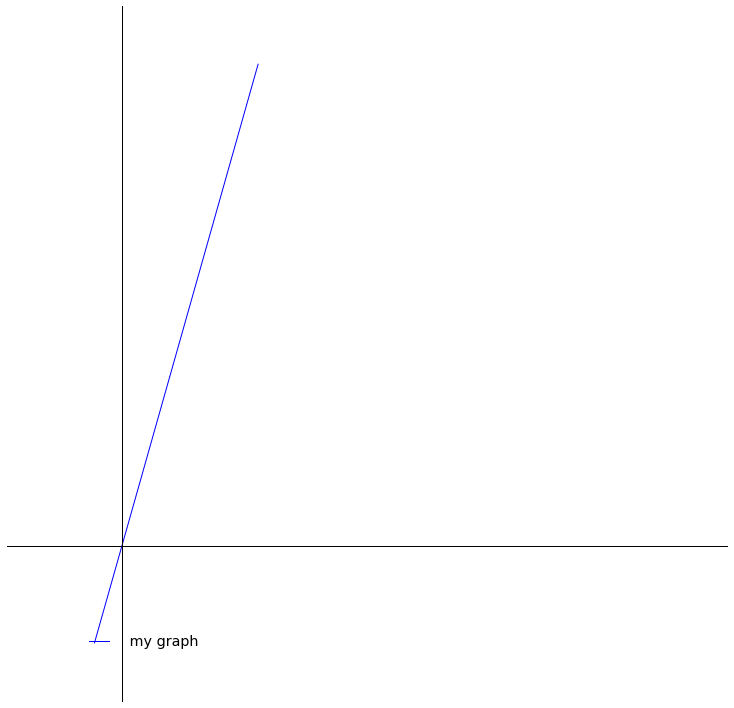

In [64]:
x = sp.Symbol('x')
test = graph(domain_set=sp.Interval(-2,20))
test.set_x_plots([-1,0,1,2,3,4,5])
test.set_y_plots([-1,0,1,2,3,4,5])
# test.set_x_ticks([1,2,sp.pi])
# test.set_y_ticks([sp.pi,sp.pi*2,sp.pi*3])
test.display()

In [66]:
class function_graph:
     
    def __init__(self, 
                 fn, # where fn is a sympy expression
                 domain_set = sp.Interval(-10,10),  #Sympy set for example an interval
                 points_to_plot = 1000, fig_width=10, fig_height=10, 
                 x_tick_mark_type='standard', y_tick_mark_type='standard', graph_buffer_over_domain=0.1):
        '''Graph function inits with the same parameters as graph with the addition of the function parameter'''
        
        self._graph = graph(domain_set, points_to_plot, fig_width, fig_height, 
                 x_tick_mark_type, y_tick_mark_type, graph_buffer_over_domain)
        self.fn = fn       
        self._graph.set_x_plots(self._calc_x_plots())
        self._graph.set_y_plots(self._calc_y_plots(points_to_plot))
        y = sp.Symbol('y')
        self._graph.set_graph_label('$' + (sp.latex(sp.Eq(y, self.fn))) + '$')
            

    def _discontinuities(self):
        if self.fn.is_constant():
            #Handle case fn=constant (no x in equation) = straight line parallel to x-axis
            return([])
        else:
            discontinuities = sp.singularities(self.fn, x)
            discontinuities_in_domain = discontinuities.intersect(self._graph.domain_set)
            sympy_list = list(discontinuities_in_domain)
            float_list = [float(x) for x in sympy_list]
            return (float_list)        
        
        
    def _calc_x_plots(self):
        '''calc plot x-values'''
        x_vals = np.linspace(float(self._graph.domain_set.start), float(self._graph.domain_set.end), self._graph.points_to_plot)
        
        # applies mask for example to prevent lines being drawn joining discontinuous portions of hyperbola, tan etc
        for discontinuity in self._discontinuities():        
            first_value_after_discontinuity=next((x for x in x_vals if x >= discontinuity), None)
            first_value_before_discontinuity=next((x for x in x_vals[::-1] if x < discontinuity), None)
            # if first_value_before_discontinuity is not None and first_value_after_discontinuity is not None:
            x_vals = np.ma.masked_where(
                (x_vals == first_value_before_discontinuity) | (x_vals==first_value_after_discontinuity), 
                x_vals)    
        
        return (x_vals)
   

    def _calc_y_plots(self, points_to_plot):
        '''calc plot y-values'''
        if self.fn.is_constant():
            #Handle case fn=constant (no x in equation) = straight line parallel to x-axis
            return([float(fn)] * points_to_plot)
        else:
            fn_lambdify = sp.lambdify(x, self.fn)
            return(fn_lambdify(self._graph.x_plots))

    
    def _graph_label(self):
        '''Returns label for graph'''
        y = sp.Symbol('y')
        return (sp.latex(sp.Eq(y, self.fn)))
    
    
    def display(self):
        self._graph.display()

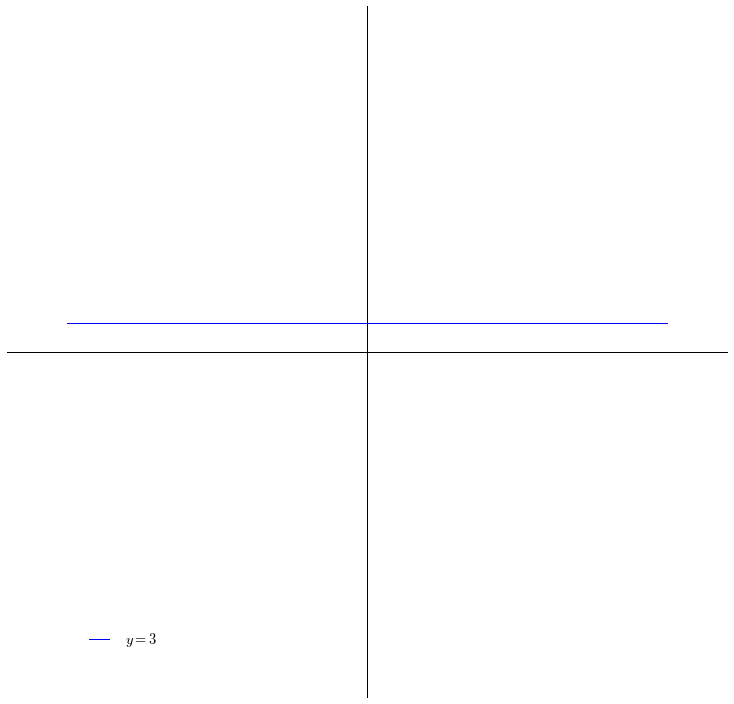

In [91]:
x = sp.Symbol('x')
# composite_test = function_graph(fn=3*x**2 - 7*x+2)
composite_test = function_graph(fn=sp.Integer(3))
composite_test.display()
# composite_test.fn.is_constant()

In [87]:
composite_test._graph._calc_x_limits()

(-12.0, 12.0)

In [15]:
# x = sp.symbols('x', real=True)
# mygraph = graph_original(graph_type = 'straight line gradient intercept form', straight_line_gradient_intercept={'m':1, 'c':5})
# mygraph = straight_line(graph_type = 'straight line point gradient form', straight_line_point_gradient={'x1':3,'y1':-1,'m':-1})
# mygraph = graph(graph_type = 'straight line two point form', straight_line_two_point= {'x1':0, 'y1':1,'x2':2,'y2':0})
# mygraph = graph(graph_type = 'straight line general form', straight_line_general_form= {'a':1, 'b':3, 'c':4})
# mygraph = graph(graph_type = 'straight line general form', straight_line_general_form= [0,1,-5])
# mygraph = graph(graph_type = 'polynomial', polynomial_coefficients = [sp.Rational(1,2),5,7], domain_from=-14, domain_to=12)
# mygraph = graph(fn=sp.sin(x))
# mygraph = graph(fn = 2*x-5)
# mygraph = graph(fn = 1/(x+1), domain_from=-10, domain_to=10, points_to_plot=1000)
# mygraph = graph(fn=sp.tan(x), domain_from=-10, domain_to=10, points_to_plot=1000)
# mygraph = graph(fn=sp.tan(sp.Rational(1,2) * x), domain_from=-10, domain_to=10, points_to_plot=1000)
# mygraph = graph(fn=5*sp.cos(sp.Rational(2,2) * x), domain_from=-10, domain_to=10, points_to_plot=1000) # , x_tick_mark_type = 'degrees'
# mygraph = graph(fn=sp.Abs(x-3)-2, domain_from=-10, domain_to=10)
# mygraph = graph(fn = 5**(-x)-7)
# mygraph = graph(fn=5 * sp.cos(x), domain_from=-10, domain_to=10, points_to_plot=1000, x_tick_mark_type = 'radians')
# mygraph = graph(fn = sp.acos(x), domain_from=-1, domain_to = 1) # , y_tick_mark_type = 'degrees' 
# mygraph = graph(fn = sp.asin(x), domain_from=-1, domain_to = 1)



# mygraph.display()